## Finite Sample Properties of Linear GMM
#Ligon Lecture , April 20, 2020
#Updated: Sara Johns, April 30, 2020


### Introduction



GMM provides a generalized way to think about instrumental
variables estimators, and we also have evidence that the finite
sample properties of these estimators may be poor.  Here we&rsquo;ll
construct a simple Monte Carlo framework within which to evaluate
the finite-sample behavior of GMM linear IV estimators.



### Asymptotic Variance of GMM estimator



If we have $\mbox{E}g_j(\beta)g_j(\beta)^\top=\Omega$ and
$\mbox{E}\frac{\partial g_j}{\partial b^\top}(\beta)=Q$ then we&rsquo;ve
seen that the asymptotic variance of the optimally weighted GMM
estimator is
$$
       V_b = \left(Q^\top\Omega^{-1}Q\right)^{-1}.
   $$



### Data Generating Process



We consider the linear IV model

\begin{align*}
   y &= X\beta + u\\
   \mbox{E}Z^\top u &= 0
\end{align*}

Thus, we need to describe processes that generate $(X,Z,u)$.

The following code block defines the important parameters governing
the DGP; this is the &ldquo;TRUTH&rdquo; we&rsquo;re designing tools to reveal.  



In [1]:
import numpy as np
from numpy.linalg import inv, norm
import statistics as stats

## Play with us!
beta = 2    # "Coefficient of interest"
gamma = 0.7    # Governs effect of u on X
sigma_u = 12  # Note assumption of homoskedasticity, 
              #we started with sigma_u=1, then increased to =10
## Play with us!

# Let Z have order ell, and X order 1, with Var([X,Z]|u)=VXZ

ell = 4 # Play with me too! Number of instruments

# Arbitrary (but deterministic) choice for VXZ
A = np.sqrt(1/np.arange(1,(ell+1)**2+1)).reshape((ell+1,ell+1)) 


## Below here we're less playful.

# Var([X,Z]|u) is constructed so that pos. def.
VXZ = A.T@A 

Q = VXZ[1:,[0]]  # EZX'

truth = (beta,gamma,sigma_u,VXZ)

## But play with Omega if you want to introduce heteroskedascity
Omega = (sigma_u**2)*VXZ[1:,1:] # E(Zu)(u'Z')

# Asymptotic variance of optimally weighted GMM estimator:
print(inv(Q.T@inv(Omega)@Q))

[[105.28666168]]


Now code to generate $N$ realizations of $(y,X,Z)$ given some &ldquo;truth&rdquo;
$(beta,gamma,sigma_u,VXZ)$:



In [2]:
from scipy.stats import distributions as iid

def dgp(N,beta,gamma,sigma_u,VXZ):
    """Generate a tuple of (y,X,Z).

    Satisfies model:
        y = X@beta + u
        E Z'u = 0
        Var(u) = sigma^2
        Cov(X,u) = gamma*sigma_u^2
        Var([X,Z}|u) = VXZ
        u,X,Z mean zero, Gaussian

    Each element of the tuple is an array of N observations.

    Inputs include
    - beta :: the coefficient of interest
    - gamma :: linear effect of disturbance on X
    - sigma_u :: Variance of disturbance
    - VXZ :: Cov([X,Z|u])
    """
    
    u = iid.norm.rvs(size=(N,1))*sigma_u

    # "Square root" of VXZ via eigendecomposition
    lbda,v = np.linalg.eig(VXZ)
    SXZ = v@np.diag(np.sqrt(lbda))

    # Generate normal random variates [X*,Z]
    XZ = iid.norm.rvs(size=(N,VXZ.shape[0]))@SXZ.T

    # But X is endogenous...
    X = XZ[:,[0]] + gamma*u
    Z = XZ[:,1:]

    # Calculate y
    y = X*beta + u

    return y,X,Z

Check on DGP:



In [3]:
N = 1000

data = dgp(N,*truth)

y,X,Z = data # Unpack tuple to check on things

# Check that we've computed things correctly:
print(VXZ)

print(np.cov(np.c_[X,Z].T) - VXZ)

[[1.36769481 1.05560708 0.90973918 0.81856253 0.75370821]
 [1.05560708 0.83046855 0.72356461 0.65585413 0.60715898]
 [0.90973918 0.72356461 0.63429023 0.57728783 0.53602129]
 [0.81856253 0.65585413 0.57728783 0.52683793 0.49014636]
 [0.75370821 0.60715898 0.53602129 0.49014636 0.45666667]]
[[7.25576089e+01 5.32614633e-01 4.53635731e-01 4.05137256e-01
  3.71122487e-01]
 [5.32614633e-01 7.13973969e-02 6.08949221e-02 5.43637146e-02
  4.97462961e-02]
 [4.53635731e-01 6.08949221e-02 5.18187914e-02 4.61941071e-02
  4.22286780e-02]
 [4.05137256e-01 5.43637146e-02 4.61941071e-02 4.11423320e-02
  3.75871407e-02]
 [3.71122487e-01 4.97462961e-02 4.22286780e-02 3.75871407e-02
  3.43246866e-02]]


### Estimation



Now that we have a data-generating process we proceed with under
   the conceit that we can observe samples generated by this process,
   but otherwise temporarily &ldquo;forget&rdquo; the properties of the DGP, and use the
   generated data to try to reconstruct aspects of the DGP.

In our example, we consider using the optimally weighted linear IV
estimator, and define a function which computes observation-level
deviations from expectations for this model. To testimate a different
model this is the function we&rsquo;d want to re-define.



In [4]:
def gj(b,y,X,Z):
    """Observations of g_j(b).

    This defines the deviations from the predictions of our model; i.e.,
    e_j = Z_ju_j, where EZ_ju_j=0.

    Can replace this function to testimate a different model.
    """
    return Z*(y - X*b)

#### Construct sample moments



Begin by defining a function to construct the sample moments given
    the data and a parameter estimate $b$:



In [5]:
def gN(b,data):
    """Averages of g_j(b).

    This is generic for data, to be passed to gj.
    """
    e = gj(b,*data)

    # Check to see more obs. than moments.
    assert e.shape[0] > e.shape[1]
    
    return e.mean(axis=0)

#### Define estimator of Egg'



Next we define a function to compute covariance matrix of moments.
Re-centering can be important in finite samples, even if irrelevant in
the limit.  Since we have $\mbox{E}g_j(\beta)=0$ under the null we may
as well use this information when constructing our weighting matrix.



In [6]:
def Omegahat(b,data):
    e = gj(b,*data)

    # Recenter! We have Eu=0 under null.
    # Important to use this information. centering is important
    e = e - e.mean(axis=0) 
    #could have writen return np.cov(e) divided by N e.shape[0]
    return e.T@e/e.shape[0]

Next, check construction of criterion given our data.  We want
something that looks nice and quadratic, at least in the neighborhood
of $\beta$.

Check construction of weighting matrix for our data at true parameter $\beta$.



In [7]:
Winv = Omegahat(beta,data) 
print(Winv)

[[121.2939989  105.45590488  95.4567761   88.28442354]
 [105.45590488  92.22220407  83.80490276  77.73000116]
 [ 95.4567761   83.80490276  76.35501319  70.95529819]
 [ 88.28442354  77.73000116  70.95529819  66.02922755]]


Define the criterion function given a weighting matrix $W$:



In [8]:
def J(b,W,data):

    m = gN(b,data) # Sample moments m  @ b
    N = data[0].shape[0]  # number of observ

    return N*m.T@W@m # Scale by sample size

Next, check construction of criterion given our data.  We want
something that looks nice and quadratic, at least in the neighborhood
of $\beta$.  Note that comparing the criterion to the critical values
of the $\chi^2$ statistic gives us an alternative way to construct
confidence intervals.



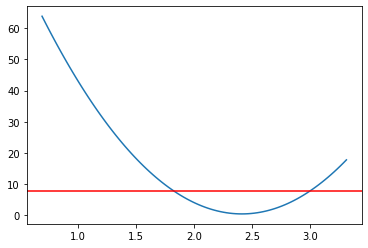

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

# Limiting distribution of criterion (under null)
limiting_J = iid.chi2(ell-1)

# Limiting SE of b should be in theory
sigma_0 = np.sqrt(inv(Q.T@inv(Winv)@Q)/N)[0][0] 

# Choose 8 sigma_0 neighborhood of "truth"
B = np.linspace(beta-4*sigma_0,beta+4*sigma_0,100)
W = inv(Winv)

#blue is the criterion function
#red line is the critical value of chi square stat

_ = plt.plot(B,[J(b,W,data) for b in B.tolist()])
_ = plt.axhline(limiting_J.isf(0.05),color='r')

#### Two Step Estimator



We next implement the two-step GMM estimator



In [10]:
from scipy.optimize import minimize_scalar

def two_step_gmm(data):

    # First step uses identity weighting matrix
    W1 = np.eye(gj(1,*data).shape[1])

    b1 = minimize_scalar(lambda b: J(b,W1,data)).x 

    # Construct 2nd step weighting matrix using
    # first step estimate of beta
    W2 = inv(Omegahat(b1,data))

    return minimize_scalar(lambda b: J(b,W2,data))

Now let&rsquo;s try it with an actual sample, just to see that things work:



In [11]:
soltn = two_step_gmm(data)

print("b=%f, J=%f, Critical J=%f" % (soltn.x,soltn.fun,limiting_J.isf(0.05)))

b=2.409469, J=0.682329, Critical J=7.814728


#### Iterated GMM

We next implement the iterated GMM estimator. This is similar to two step, but we will continue the process until we get convergence. There was discussion about whether convergence means convergence in b or convergence in $\hat{\Omega}$. I referenced Hansen, Heaton, and Yaron (1996) which uses convergence in b and so that is what I do here.

In [12]:
def iterated_gmm(data, epsilon):

    # First use identity weighting matrix
    W1 = np.eye(gj(1,*data).shape[1])
    
    # set initial b_1, b_2 for while loop
    b_1 = 10
    b_2 = 0
    
    j = 1
    
    # Now iterate: will continue until norm is less than some epsilon
    while norm(b_2 - b_1) > epsilon:
        
        j += 1
        
        # calculate b1 
        b_1 = minimize_scalar(lambda b: J(b,W1,data)).x

        # Update weighting matrix
        W1 = inv(Omegahat(b_1,data))
        
        # calculate b2
        b_2 = minimize_scalar(lambda b: J(b,W1,data)).x
    
        if j > 10000:
            break
    
    # get all the stuff we want
    b_final = minimize_scalar(lambda b: J(b,W1,data))

    return(b_final) 

Now test it:

In [13]:
soltn_itt = iterated_gmm(data, 0.00001)

print("b=%f, J=%f, Critical J=%f" % (soltn_itt.x,soltn_itt.fun,limiting_J.isf(0.05)))

b=2.409388, J=0.708159, Critical J=7.814728


#### Continuously updated GMM

Now we write the weighting matrix as a function of b. 

In [14]:
def J_cu(b,data):

    m = gN(b,data) # Sample moments m  @ b
    N = data[0].shape[0]  # number of observ
    
    # continuously updating minimizes the objective with a weighting matrix that is a function of b
    return N*m.T@inv(Omegahat(b,data))@m # Scale by sample size

Now test it:

In [15]:
soltn_cu = minimize_scalar(lambda b: J_cu(b,data))

print("b=%f, J=%f, Critical J=%f" % (soltn_cu.x,soltn_cu.fun,limiting_J.isf(0.05)))

b=2.392904, J=0.696868, Critical J=7.814728


### Monte Carlo Experiment



Now our experiment begins.  We set our frequentist hats firmly on our
heads, and draw repeated samples of data, each generating a
corresponding estimate of beta.  Then the empirical distribution of
these samples tells us about the *finite* sample performance of our estimator.

We&rsquo;ll generate a sample of estimates of $b$ by drawing repeated
samples of size $N$:



In [16]:
N = 1000 # Sample size

D = 1000 # Monte Carlo draws

b_draws_2s = []
J_draws_2s = []
b_draws_itt = []
J_draws_itt = []
b_draws_cu = []
J_draws_cu = []
for d in range(D):
    mc_data = dgp(N,*truth)
    soltn = two_step_gmm(mc_data)
    b_draws_2s.append(soltn.x)
    J_draws_2s.append(soltn.fun)
    
    soltn_itt = iterated_gmm(mc_data, 0.00001)
    b_draws_itt.append(soltn_itt.x)
    J_draws_itt.append(soltn_itt.fun)
    
    soltn_cu = minimize_scalar(lambda b: J_cu(b,mc_data))
    b_draws_cu.append(soltn_cu.x)
    J_draws_cu.append(soltn_cu.fun)

In [17]:
# Function for histograms (thanks to Connor):
def graph_hist(data, caption):
    """Plot a histogram of the relevant data"""
    plt.hist(data, bins='auto')
    plt.title(caption)
    plt.axvline(stats.mean(data), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(stats.median(data), color='w', linestyle='dashed', linewidth=1)
    plt.axvline(beta, color='r', linestyle='dashed', linewidth=1)
    plt.show()
    print("Estimate:", stats.mean(data))

Plot two-step GMM:

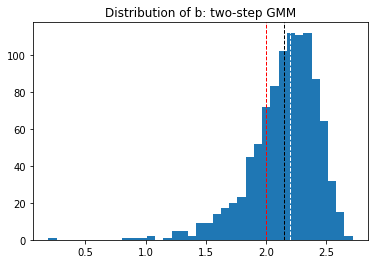

Estimate: 2.152038561919423


In [18]:
graph_hist(b_draws_2s,"Distribution of b: two-step GMM")

Plot iterated GMM:

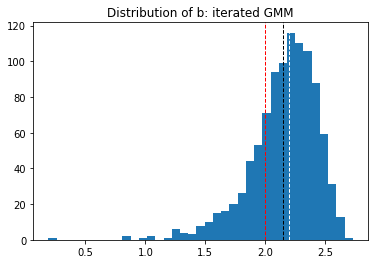

Estimate: 2.152771577953264


In [19]:
graph_hist(b_draws_itt,"Distribution of b: iterated GMM")

Plot continuously updated GMM:

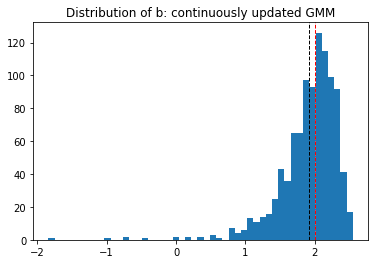

Estimate: 1.9105362225918872


In [20]:
graph_hist(b_draws_cu,"Distribution of b: continuously updated GMM")

### Distribution of Monte Carlo draws vs. Asymptotic distribution



Compare Monte Carlo standard errors with asymptotic approximation:



In [21]:
# Limiting distribution of estimator

limiting_b = iid.norm(scale=sigma_0)

print("Bootstrapped standard errors two step: %g" % np.std(b_draws_2s))
print("Bootstrapped standard errors iterated: %g" % np.std(b_draws_itt))
print("Bootstrapped standard errors CU: %g" % np.std(b_draws_cu))
print("Asymptotic approximation: %g" % sigma_0)
print("Critical value for J statistic: %g (5%%)" % limiting_J.isf(.05))

Bootstrapped standard errors two step: 0.281751
Bootstrapped standard errors iterated: 0.281957
Bootstrapped standard errors CU: 0.428455
Asymptotic approximation: 0.327744
Critical value for J statistic: 7.81473 (5%)


Now construct probability plot (bootstrapped $b$s vs. quantiles of
limiting distribution) - two step GMM:



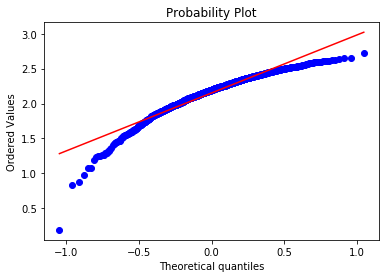

In [22]:
from scipy.stats import probplot

_ = probplot(b_draws_2s,dist=limiting_b,fit=False,plot=plt)

And for iterated GMM:

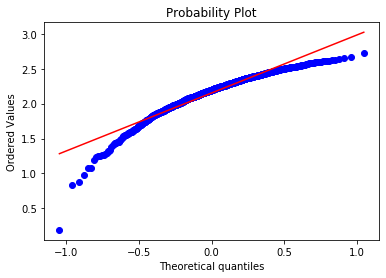

In [23]:
_ = probplot(b_draws_itt,dist=limiting_b,fit=False,plot=plt)

And for continuously updated GMM:

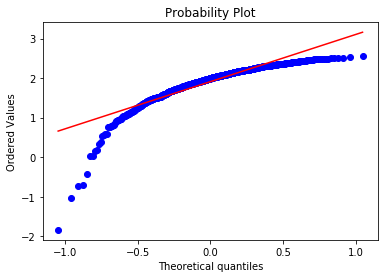

In [24]:
_ = probplot(b_draws_cu,dist=limiting_b,fit=False,plot=plt)

Next, consider the a $p$-$p$ plot for $J$ statistics (recall these
should be distributed $\chi^2_{\ell-1}$).



In [25]:
def ppplot(data,dist):
    data = np.array(data)

    # Theoretical CDF, evaluated at points of data
    P = [dist.cdf(x) for x in data.tolist()]

    # Empirical CDF, evaluated at points of data
    Phat = [(data<x).mean() for x in data.tolist()]

    fig, ax = plt.subplots()
    
    ax.scatter(P,Phat)
    ax.plot([0,1],[0,1],color='r') # Plot 45
    ax.set_xlabel('Theoretical Distribution')
    ax.set_ylabel('Empirical Distribution')
    ax.set_title('p-p Plot')

    return ax

For two-step GMM:

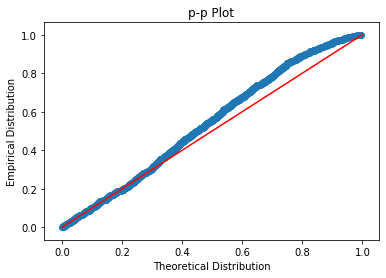

In [26]:
_ = ppplot(J_draws_2s, limiting_J)

For iterated GMM:

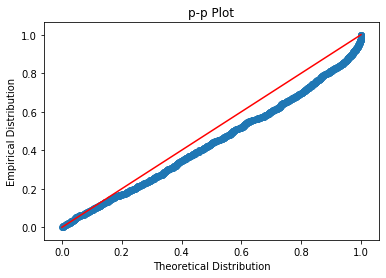

In [27]:
_ = ppplot(J_draws_itt, limiting_J)

For continuously updated GMM:

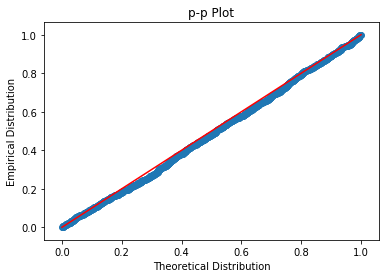

In [28]:
_ = ppplot(J_draws_cu, limiting_J)

#### Takeaways:
With small sample size, $\ell > k$ , and large variance (high $\sigma_u$) we see that
- Continuously updated GMM has less bias, but fatter tails
- The limiting distributions of b are similar
- The J statistic is better for continuously updated GMM, better to use to test for overidentifying restrictions

#### Notes about other parameters tested:

1. In just identified case, methods are the same.
2. Small variance tends to give us nice results for all methods.
3. Similarly, large sample size (even when variance is high) gives us nice results.